In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import numpy as np

import unicodedata
import re
import os
import io
from pathlib import Path

In [2]:
%%capture
!wget http://www.manythings.org/anki/rus-eng.zip
!rm ru_en -r
!mkdir ru_en
!unzip rus-eng.zip -d ru_en
!rm rus-eng.zip

In [3]:
!ls ru_en

_about.txt  rus.txt


In [4]:
data_path = Path('/content/ru_en/rus.txt')

In [5]:
def preprocess_sentence(w):
  w = w.lower().strip()

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Zа-яА-ЯЁё~?.!,']+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [6]:
preprocess_sentence("This is example sentence.")

'<start> this is example sentence . <end>'

In [7]:
def create_dataset(data_path: Path, num_examples: int) -> zip:
  lines = data_path.read_text(encoding='UTF-8').strip().split('\n')

  word_pairs = [[preprocess_sentence(sent) for sent in line.split('\t')[:2]] for line in lines[:num_examples]]

  return zip(*word_pairs)

def load_dataset(data_path: Path, num_examples: int) -> tuple:
  # creating cleaned input, output pairs
  target_lang, input_lang = create_dataset(data_path, num_examples)

  input_tensor, input_lang_tokenizer = tokenize(input_lang)
  target_tensor, target_lang_tokenizer = tokenize(target_lang)

  return input_tensor, target_tensor, input_lang_tokenizer, target_lang_tokenizer

def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

  return tensor, lang_tokenizer

In [8]:
en, ru = create_dataset(data_path, None)
print(f'len(en) = {len(en)}, len(ru) = {len(ru)}')
print(en[-1])
print(ru[-1])

len(en) = 451436, len(ru) = 451436
<start> doubtless there exists in this world precisely the right woman for any given man to marry and vice versa but when you consider that a human being has the opportunity of being acquainted with only a few hundred people , and out of the few hundred that there are but a dozen or less whom he knows intimately , and out of the dozen , one or two friends at most , it will easily be seen , when we remember the number of millions who inhabit this world , that probably , since the earth was created , the right man has never yet met the right woman . <end>
<start> несомненно , для каждого мужчины в этом мире где то есть подходящая женщина , которая может стать ему женой , обратное верно и для женщин . но если учесть , что у человека может быть максимум несколько сотен знакомых , из которых лишь дюжина , а то и меньше , тех , кого он знает близко , а из этой дюжины у него один или от силы два друга , то можно легко увидеть , что с учётом миллионов живущих

In [9]:
NUM_EXAMPLES = 100000
input_tensor, target_tensor, input_lang_tokenizer, target_lang_tokenizer = load_dataset(data_path, NUM_EXAMPLES)

In [10]:
# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]
max_length_targ, max_length_inp

(11, 15)

In [11]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

80000 80000 20000 20000


In [12]:
def show_mapping(tokenizer, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, tokenizer.index_word[t]))

print ("Input Language; index to word mapping")
show_mapping(input_lang_tokenizer, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
show_mapping(target_lang_tokenizer, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
6 ----> том
91 ----> сегодня
316 ----> выиграл
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
5 ----> tom
235 ----> won
152 ----> today
3 ----> .
2 ----> <end>


In [13]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
STEPS_PER_EPOCH = len(input_tensor_train)//BATCH_SIZE
EMBEDDING_DIM = 300
UNITS = 1024
WITH_ATTENTION = True
vocab_inp_size = len(input_lang_tokenizer.word_index)+1
vocab_tar_size = len(target_lang_tokenizer.word_index)+1

In [14]:
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [15]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 15]), TensorShape([64, 11]))

In [16]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units, batch_size, with_attention=True):
        super(Encoder, self).__init__()

        self.batch_size = batch_size
        self.rnn_units = rnn_units
        self.with_attention = with_attention

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.rnn_units, return_sequences=with_attention, return_state=True, recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state

    def get_zero_hidden_state(self):
        return tf.zeros((self.batch_size, self.rnn_units))

In [17]:
encoder = Encoder(vocab_inp_size, EMBEDDING_DIM, UNITS, BATCH_SIZE, with_attention=WITH_ATTENTION)

In [18]:
# sample input
sample_hidden = encoder.get_zero_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 15, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [19]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [20]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 15, 1)


In [21]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units, batch_size, with_attention=True):
        super(Decoder, self).__init__()

        self.batch_size = batch_size
        self.rnn_units = rnn_units
        self.with_attention = with_attention
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.rnn_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        # used for attention
        self.attention = BahdanauAttention(self.rnn_units)

    def call(self, x, hidden, enc_output=None):
        attention_weights = None

        x = self.embedding(x) # x shape after passing through embedding == (batch_size, 1, embedding_dim)

        if self.with_attention:
          context_vector, attention_weights = self.attention(hidden, enc_output)
          # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
          x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
          output, state = self.gru(x)
        else:
          output, state = self.gru(x, initial_state=hidden)

        output = tf.reshape(output, (-1, output.shape[2])) # output shape == (batch_size * 1, hidden_size)
        x = self.fc(output) # output shape == (batch_size, vocab)

        return x, state, attention_weights

In [22]:
decoder = Decoder(vocab_tar_size, EMBEDDING_DIM, UNITS, BATCH_SIZE, with_attention=WITH_ATTENTION)

In [23]:
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)
print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 7335)


In [24]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_funcion(real, pred):
    
    loss_ = loss_object(real, pred)

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.cast(mask, dtype=loss_.dtype)

    loss_ *= mask

    return tf.reduce_mean(loss_)

In [25]:
@tf.function
def train_step(input, target, encoder_hidden):
    loss = 0
    enc_output = None

    with tf.GradientTape() as tape:
        enc_output, encoder_hidden = encoder(input, encoder_hidden)

        decoder_hidden = encoder_hidden

        decoder_input = tf.expand_dims([target_lang_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, target.shape[1]):
            # passing enc_output to the decoder
            predictions, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, enc_output)

            loss += loss_funcion(target[:, t], predictions)

            # using teacher forcing
            decoder_input = tf.expand_dims(target[:, t], 1)

    batch_loss = (loss / int(target.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [26]:
EPOCHS = 50

for epoch in range(EPOCHS):
    
    encoder_hidden = encoder.get_zero_hidden_state()
    total_loss = 0

    for (batch, (input, target)) in enumerate(dataset.take(STEPS_PER_EPOCH)):
      batch_loss = train_step(input, target, encoder_hidden)
      total_loss += batch_loss

      if batch % 100 == 0: print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss:.4f}')

    print(f'Epoch {epoch+1} Batch {batch} Loss {total_loss / STEPS_PER_EPOCH:.4f}')

Epoch 1 Batch 0 Loss 4.6529
Epoch 1 Batch 100 Loss 2.0656
Epoch 1 Batch 200 Loss 1.8595
Epoch 1 Batch 300 Loss 1.6369
Epoch 1 Batch 400 Loss 1.5781
Epoch 1 Batch 500 Loss 1.3535
Epoch 1 Batch 600 Loss 1.2668
Epoch 1 Batch 700 Loss 1.2023
Epoch 1 Batch 800 Loss 1.1252
Epoch 1 Batch 900 Loss 1.0360
Epoch 1 Batch 1000 Loss 1.0104
Epoch 1 Batch 1100 Loss 1.0385
Epoch 1 Batch 1200 Loss 0.6936
Epoch 1 Batch 1249 Loss 1.3795
Epoch 2 Batch 0 Loss 0.7279
Epoch 2 Batch 100 Loss 0.6859
Epoch 2 Batch 200 Loss 0.6208
Epoch 2 Batch 300 Loss 0.6567
Epoch 2 Batch 400 Loss 0.5188
Epoch 2 Batch 500 Loss 0.5312
Epoch 2 Batch 600 Loss 0.6020
Epoch 2 Batch 700 Loss 0.4752
Epoch 2 Batch 800 Loss 0.6851
Epoch 2 Batch 900 Loss 0.6526
Epoch 2 Batch 1000 Loss 0.4371
Epoch 2 Batch 1100 Loss 0.4799
Epoch 2 Batch 1200 Loss 0.4578
Epoch 2 Batch 1249 Loss 0.5724
Epoch 3 Batch 0 Loss 0.3104
Epoch 3 Batch 100 Loss 0.3438
Epoch 3 Batch 200 Loss 0.2947
Epoch 3 Batch 300 Loss 0.3685
Epoch 3 Batch 400 Loss 0.3151
Epoch 3 

In [27]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [input_lang_tokenizer.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, UNITS))]

  enc_out, enc_hidden = encoder(inputs, hidden)
  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([target_lang_tokenizer.word_index['<start>']], 0)

  for t in range(max_length_targ):

    predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

    if WITH_ATTENTION:
      # storing the attention weights to plot later on
      attention_weights = tf.reshape(attention_weights, (-1, ))
      attention_plot[t] = attention_weights.numpy()

    # storing the attention weights to plot later on
    predicted_id = tf.argmax(predictions[0]).numpy()
    result += target_lang_tokenizer.index_word[predicted_id] + ' '

    if target_lang_tokenizer.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [28]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [29]:
def translate(sentence):

  result, sentence, attention_plot = evaluate(sentence)

  if WITH_ATTENTION:
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

Проверка перевода

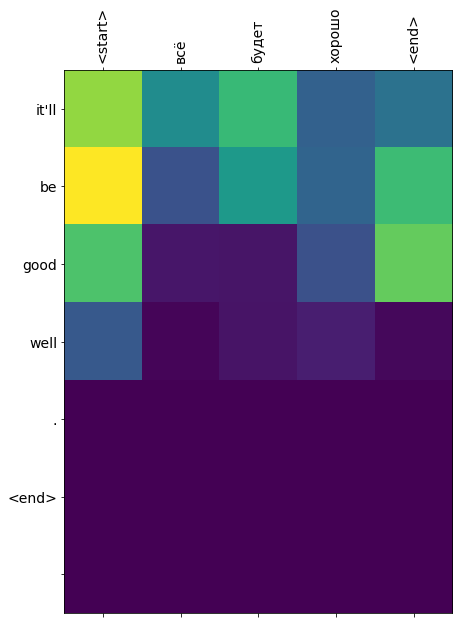

Input: <start> всё будет хорошо <end>
Predicted translation: it'll be good well . <end> 


In [30]:
translate('Всё будет хорошо')

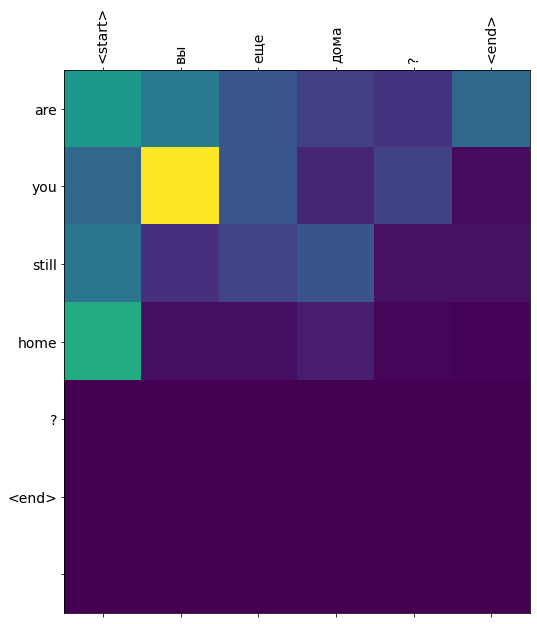

Input: <start> вы еще дома ? <end>
Predicted translation: are you still home ? <end> 


In [31]:
translate('Вы еще дома?')

In [32]:
text = \
"""
Белеет парус одинокой
В тумане моря голубом!..
Что ищет он в стране далекой?
Что кинул он в краю родном?..

Играют волны — ветер свищет,
И мачта гнется и скрипит…
Увы! он счастия не ищет
И не от счастия бежит!

Под ним струя светлей лазури,
Над ним луч солнца золотой…
А он, мятежный, просит бури,
Как будто в бурях есть покой!
"""

In [33]:
%%capture
!pip install transformers[sentencepiece]
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

In [34]:
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-ru-en")
model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-ru-en")

/usr/local/lib/python3.8/dist-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [35]:
translator_ru_en = pipeline("translation", model=model, tokenizer=tokenizer, device=0)

Перевод

In [36]:
translation = translator_ru_en(text)[0]['translation_text']
translation

"What is he looking for in the land of the faraway? What did he throw at the edge of his native country?... the waves are playing, the wind is whistling, and the mast is racing and squeaking... alas! he's not looking for happiness and he's not running for happiness! He's got a stream of light lasuries and a sunshine of gold over him... and he, the rebel, is asking for storms as if there was peace in the storms!"

In [37]:
tokenizer1 = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-ru")
model1 = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-ru")
translator_en_ru = pipeline('translation', model=model1, tokenizer=tokenizer1, device=0)

In [38]:
back_translation = translator_en_ru(translation)[0]['translation_text']
back_translation

'Что он ищет в стране далекой? он не ищет счастья и не бежит к счастью! у него есть поток светлых ласеров и золотых солнечных лучей над ним... и он, мятежник, просит штормов, как если бы в штормах был мир!'